# Import modules (google colab syntax !)

In [1]:
!pip install lifelines
!pip install sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 2.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=4a911f36b0e38ad40f1811474ead0f54b50c7103c5a0a688bd2d56784b5f9fb3
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Mounted at

# Fetch data and define model

In [2]:
# Load Data
train_data_path = '/content/drive/MyDrive/train_data.csv'
test_data_path = '/content/drive/MyDrive/test_data.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Preprocessing
X_train = train_data.drop(columns=['Label', 'Event'])  # Include all features except target and event
y_train = train_data['Label']  # Target column

X_test = test_data.drop(columns=['Label', 'Event'])  # Include all features except target and event
y_test = test_data['Label']  # Target column

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Custom Loss Function: Negative Partial Log Likelihood
def cox_ph_loss(event, log_hazard_ratio):
    """
    event: Binary censoring indicator (1 if event occurred, 0 if censored)
    log_hazard_ratio: Predicted log hazard ratios
    """
    hazard_ratio = tf.exp(log_hazard_ratio)
    log_cumulative_hazard = tf.math.log(tf.cumsum(hazard_ratio, axis=0, reverse=True))
    uncensored_likelihood = log_hazard_ratio - log_cumulative_hazard
    censored_likelihood = uncensored_likelihood * event
    return -tf.reduce_mean(censored_likelihood)

# Build the DeepSurv Model with Hyperparameters
class DeepSurv(tf.keras.Model):
    def __init__(self, input_dim, hidden_layers, learning_rate=1e-3,
                 dropout_rate=0.3, l1_reg=0.0, l2_reg=1e-4, batch_norm=False):
        """
        Parameters:
        - input_dim: Number of input features
        - hidden_layers: List of units in each hidden layer
        - learning_rate: Learning rate for training
        - dropout_rate: Dropout percentage after each hidden layer
        - l1_reg: L1 regularization coefficient
        - l2_reg: L2 regularization coefficient
        - batch_norm: Boolean, whether to use batch normalization
        """
        super(DeepSurv, self).__init__()
        self.hidden_layers = []
        for units in hidden_layers:
            self.hidden_layers.append(layers.Dense(
                units, activation='relu',
                kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)
            ))
            if batch_norm:
                self.hidden_layers.append(layers.BatchNormalization())
            self.hidden_layers.append(layers.Dropout(dropout_rate))
        self.output_layer = layers.Dense(1, activation=None)  # Log hazard ratio
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x, training=training)
        return self.output_layer(x)



# Set hyperparameters and train DeepSurv


In [3]:
# Initialize Model with Full Hyperparameter Control
# -------------------------------------------------
input_dim = X_train_scaled.shape[1]
hidden_layers = [128, 64, 32]  # Architecture
learning_rate = 1e-3
dropout_rate = 0.4
l1_reg = 1e-05
l2_reg = 0.0001
batch_norm = False

# Initialize DeepSurv model
deep_surv = DeepSurv(input_dim, hidden_layers, learning_rate, dropout_rate, l1_reg, l2_reg, batch_norm)

# Compile the model with Cox Proportional Hazards loss
deep_surv.compile(optimizer=deep_surv.optimizer, loss=cox_ph_loss)

# Train the model on the training data
deep_surv.fit(
    X_train_scaled,
    y_train,
    batch_size=32,
    epochs=50,
    verbose=1
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.4885
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3263
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4245
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3740
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3965
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4186
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2908
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2838
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2885
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2606
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2087
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2549
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2989
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2052
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2643
Epoch 16

# Calculate risk scores

In [4]:

# Predict Risk Scores for Training Data
# -------------------------------------
risk_scores_train = deep_surv.predict(X_train_scaled).flatten()

# Step 2: Compute and Simplify the Baseline Hazard Function
# ---------------------------------------------------------
# Sort data by survival times
survival_times = train_data['DssTime']  # Use the correct survival time column
sorted_indices = np.argsort(survival_times)  # Sort by survival times
sorted_times = survival_times.iloc[sorted_indices]  # Sorted survival times
sorted_risks = np.exp(risk_scores_train[sorted_indices])  # Align risk scores with sorted times
# Step 2: Compute Baseline Hazard
unique_times, counts = np.unique(sorted_times, return_counts=True)  # Unique times and their counts
cumulative_baseline_hazard = []
risk_sum = np.sum(sorted_risks)

for time, event_count in zip(unique_times, counts):
    hazard = event_count / risk_sum  # Events / At-risk
    if cumulative_baseline_hazard:
        cumulative_baseline_hazard.append(cumulative_baseline_hazard[-1] + hazard)  # Add to cumulative
    else:
        cumulative_baseline_hazard.append(hazard)  # First time point
    risk_sum -= np.sum(sorted_risks[sorted_times == time])  # Subtract patients who are no longer at risk

# Clip the cumulative baseline hazard to prevent extreme values
cumulative_baseline_hazard = np.clip(cumulative_baseline_hazard, 1e-6, None)

# Step 3: Predict Risk Scores for Test Data
risk_scores_test = deep_surv.predict(X_test_scaled).flatten()

# Step 4: Calculate Survival Probabilities for Test Data
# ------------------------------------------------------
time_points = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Interpolate baseline hazard for specified time points
baseline_hazards = np.interp(
    time_points,
    unique_times,
    cumulative_baseline_hazard,
    left=cumulative_baseline_hazard[0],
    right=cumulative_baseline_hazard[-1]
)

# Calculate survival probabilities
# Compute survival probabilities for all test patients
survival_probabilities = {}
for t, baseline_hazard in zip(time_points, baseline_hazards):
    # Correctly compute risk factors for each patient
    risk_factors = np.exp(risk_scores_test)
    risk_factors = np.clip(np.exp(risk_scores_test), 1e-3, 1e3)  # Adjust range to [1e-3, 1e3]

    # Temporal decay factor (learnable)
    # innovation
    #temporal_decay = 1#np.exp(0.01 * t)  # Adjust the decay rate (0.1) to control how quickly probabilities decrease

    # Adjusted survival probabilities
    survival_probabilities[t] = np.exp(-baseline_hazard * risk_factors)#* temporal_decay)
    # Calculate survival probabilities at time t for all patients
    #survival_probabilities[t] = np.maximum(survival_probabilities[t], 1e-6)  # Prevent 0 probabilities

    #survival_probabilities[t] = np.maximum(survival_probabilities[t], 1e-6)  # Prevent probabilities from being 0

# ------------------------------------------------
# This mimics a simpler model without a baseline hazard
time_point = 60  # Use t=60 for predictions
simplified_survival_probabilities = np.exp(-np.exp(risk_scores_test) * time_point)# * temporal_decay)

# Step 5: Use t=60 for Predictions
# --------------------------------
# Choose survival probabilities based on the method (baseline or simplified)
t60_probabilities_baseline = survival_probabilities[60]
t60_probabilities_simplified = simplified_survival_probabilities

# Predict labels based on thresholds
optimal_threshold = 0.50  # Adjust threshold as necessary
# model with baseline function
predicted_labels_t60_baseline = (t60_probabilities_baseline <= optimal_threshold).astype(int)
# model without baseline function
predicted_labels_t60_simplified = (t60_probabilities_simplified <= 0.000001).astype(int)




15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


# Save predictions in a dataframe

In [5]:

# Save Predictions for All Time Points
# -------------------------------------
results = pd.DataFrame(survival_probabilities)
results['Predicted Label (Baseline, t=60)'] = predicted_labels_t60_baseline
results['Predicted Label (Simplified, t=60)'] = predicted_labels_t60_simplified
results['True Label'] = y_test
results_path = '/content/drive/MyDrive/survival_predictions.csv'
results.to_csv(results_path, index=False)

# Evaluate model

In [10]:
# Evaluate Model for t=60
# ------------------------
accuracy_baseline = accuracy_score(y_test, predicted_labels_t60_baseline)
roc_auc_baseline = roc_auc_score(y_test, predicted_labels_t60_baseline)

accuracy_simplified = accuracy_score(y_test, predicted_labels_t60_simplified)
roc_auc_simplified = roc_auc_score(y_test, predicted_labels_t60_simplified)

print(f"Baseline Model - Accuracy (t=60): {accuracy_baseline:.2f}, ROC AUC: {roc_auc_baseline:.2f}")
print(f"Simplified Model - Accuracy (t=60): {accuracy_simplified:.2f}, ROC AUC: {roc_auc_simplified:.2f}")


# C-Index for Training Data
from lifelines.utils import concordance_index

# C-Index for Training Data
c_index_train = concordance_index(X_train["DssTime"], -risk_scores_train, event_observed=np.ones_like(y_train))
print(f"C-Index (Training): {c_index_train:.2f}")

# C-Index for Test Data
c_index_test = concordance_index(X_test["DssTime"], -risk_scores_test, event_observed=np.ones_like(y_test))
print(f"C-Index (Test): {c_index_test:.2f}")


Baseline Model - Accuracy (t=60): 0.96, ROC AUC: 0.95
Simplified Model - Accuracy (t=60): 0.96, ROC AUC: 0.95
C-Index (Training): 0.87
C-Index (Test): 0.89


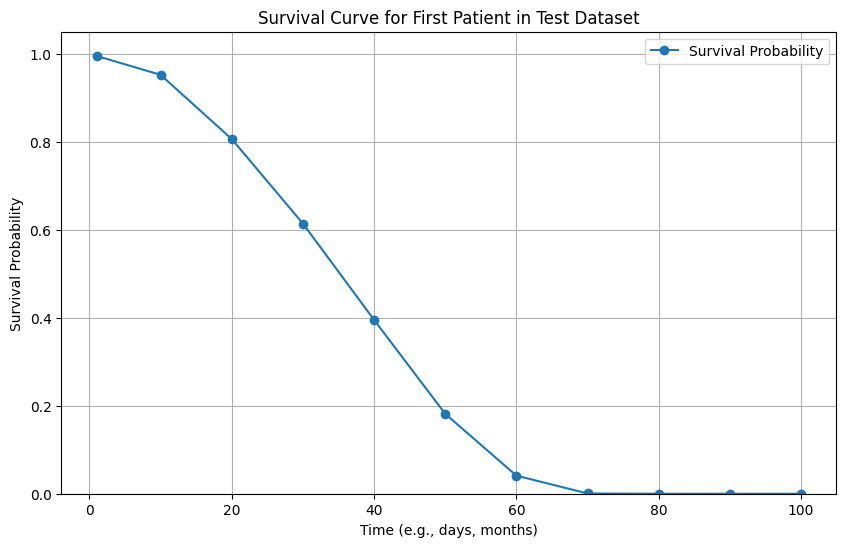

In [19]:
# Extract survival probabilities for the 5th patient
import matplotlib.pyplot as plt
first_patient_probabilities = [survival_probabilities[t][0] for t in time_points]

# Plot the survival curve for the first patient
plt.figure(figsize=(10, 6))
plt.plot(time_points, first_patient_probabilities, marker='o', label="Survival Probability")
plt.title("Survival Curve for Patient in Test Dataset")
plt.xlabel("Time (e.g., days, months)")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)  # Ensure the y-axis is between 0 and 1
plt.grid(True)
plt.legend()
plt.show()

In [12]:
for i in time_points:
  print(i)
  print(survival_probabilities[i][1])

1
0.9999957
10
0.9999575
20
0.99981385
30
0.9995788
40
0.999198
50
0.9985268
60
0.9972457
70
0.993598
80
0.98616105
90
0.9446013
100
0.83574945


In [17]:
predicted_labels_t60_baseline[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0])